## Goals

- better understand the use of unsupervised learning techniques
- use a variety of methods and models
- explore hyperparamater tuning

## The Dataset

Here I will use the [FIFA2019 dataset](https://www.kaggle.com/karangadiya/fifa19) from Kaggle. I will import it from Thinkful's postgreSQL server.

### Import Libraries and Define Functions

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sqlalchemy import create_engine

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def print_nulls(df):
    out = pd.Series({'Column': 'Percentage of nulls', '-----' : '-----'}
                   ).append(df.isnull().sum()*100/df.isnull().isnull().count())
   
    return print_full(out)

In [3]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

### Load the dataset

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'fifa19'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
    
query1='''
SELECT
    *
FROM
    fifa19
'''
    
    
df = pd.read_sql_query(query1, con=engine)
engine.dispose()

In [5]:
df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [ ]:
print_nulls(df)

In [6]:
# Make column names lowercase for ease and consistency
df.columns= df.columns.str.lower()

# Drop a few unnecessary columns
df.drop(['id', 'name', 'photo', 'flag', 'club logo', 'real face',
       'jersey number', 'joined', 'loaned from', 'contract valid until']
        , axis=1, inplace=True)

In [7]:
# Drop rows with missing values
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14743 entries, 0 to 18206
Data columns (total 78 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       14743 non-null  int64  
 1   nationality               14743 non-null  object 
 2   overall                   14743 non-null  int64  
 3   potential                 14743 non-null  int64  
 4   club                      14743 non-null  object 
 5   value                     14743 non-null  object 
 6   wage                      14743 non-null  object 
 7   special                   14743 non-null  int64  
 8   preferred foot            14743 non-null  object 
 9   international reputation  14743 non-null  float64
 10  weak foot                 14743 non-null  float64
 11  skill moves               14743 non-null  float64
 12  work rate                 14743 non-null  object 
 13  body type                 14743 non-null  object 
 14  positi

In [9]:
df['wage'] = df['wage'].apply(lambda x: int(str(x).replace('€', '').replace('K', '')
                                           ) * 1000 if 'K' in str(x) else x)

df['wage'] = df['wage'].apply(lambda x: int(str(x).replace('€', '').replace('M', '')
                                           ) * 1000000 if 'M' in str(x) else x)

df['wage'] = df['wage'].apply(lambda x: 0 if str(x) == '€0' else x)

In [10]:
df['value'] = df['value'].apply(lambda x: float(str(x).replace('€', '').replace('K', '')
                                           ) * 1000 if 'K' in str(x) else x)

df['value'] = df['value'].apply(lambda x: float(str(x).replace('€', '').replace('M', '')
                                           ) * 1000000 if 'M' in str(x) else x)

df['value'] = df['value'].apply(lambda x: 0 if str(x) == '€0' else x)

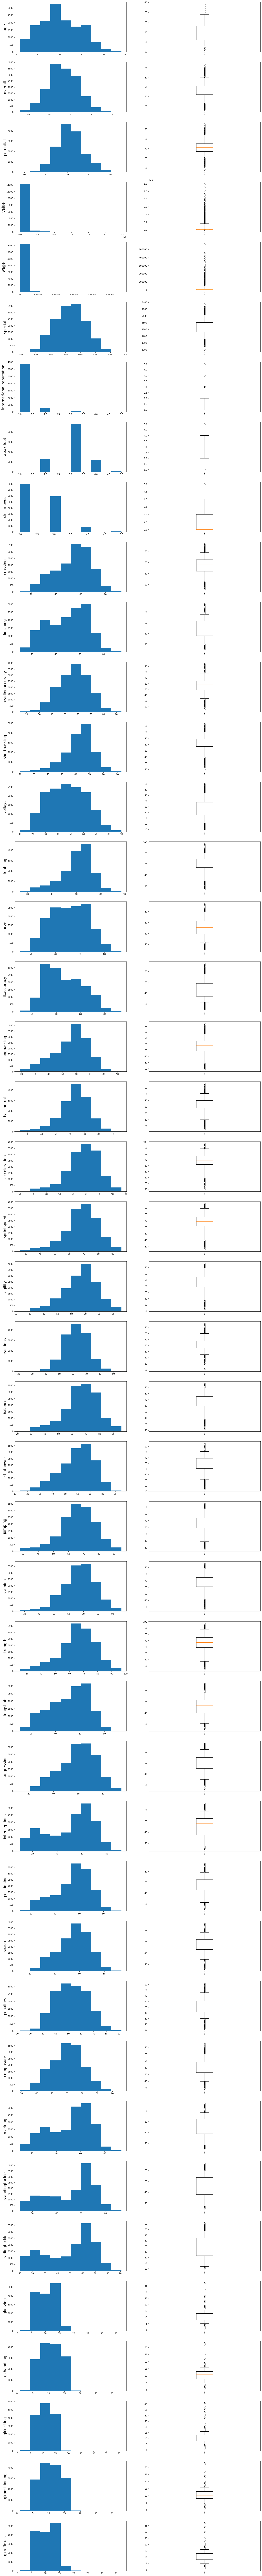

In [11]:
plot_hist_boxplot(df.select_dtypes(include='number'))

<AxesSubplot:>

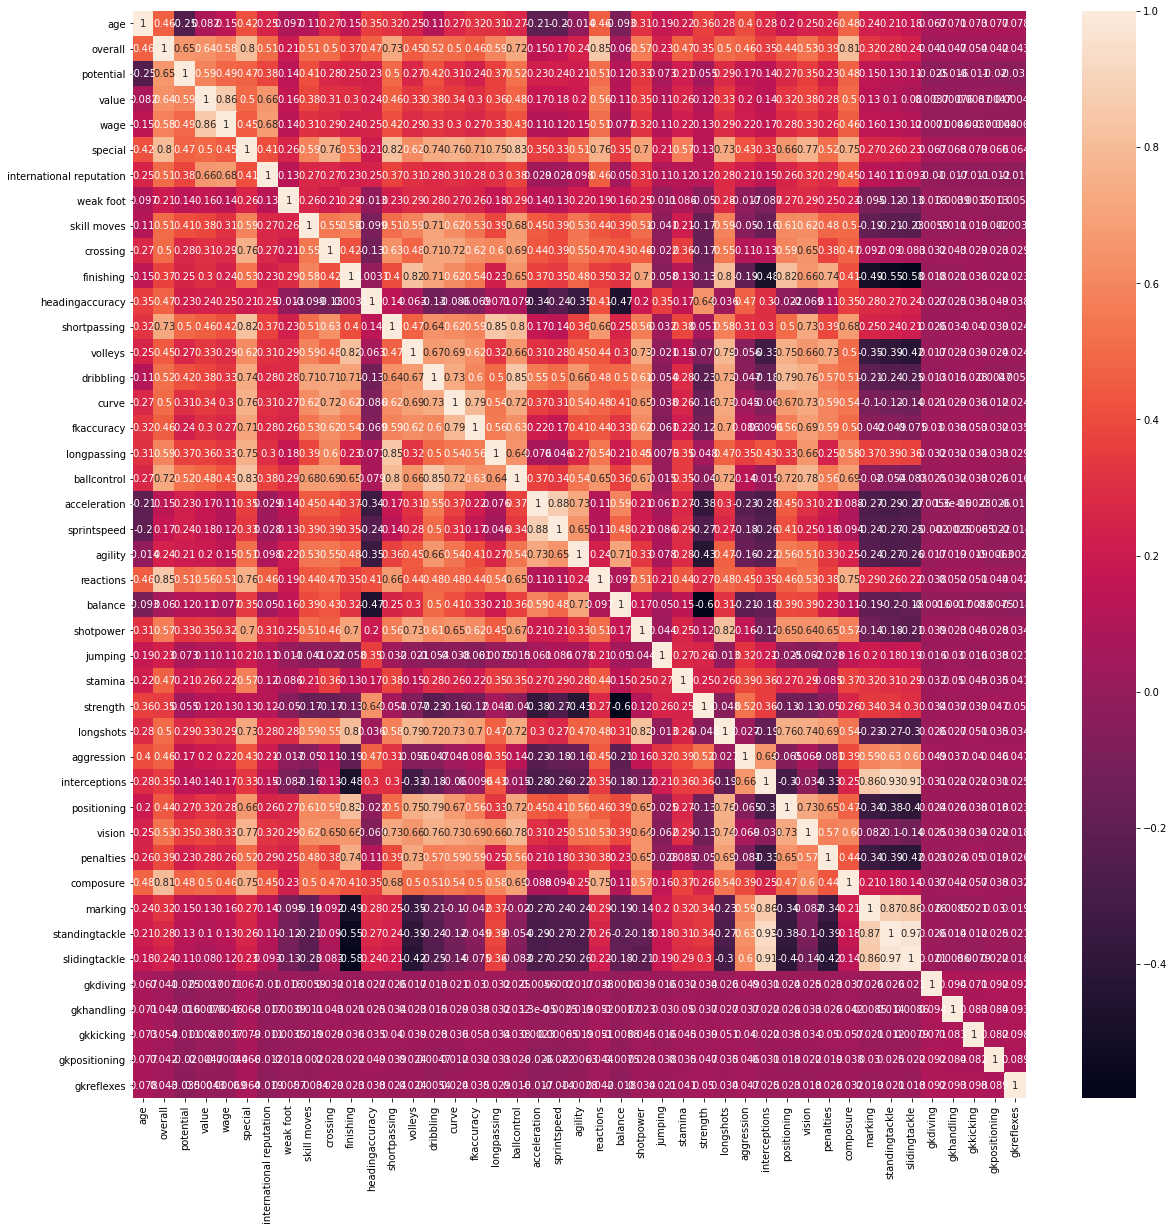

In [82]:
corr = df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True)

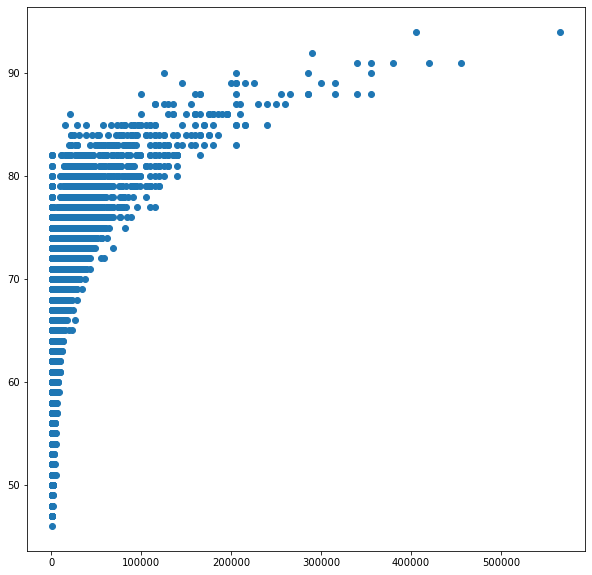

In [12]:
plt.figure(figsize=(10,10))
plt.scatter(df['wage'], df['overall'])

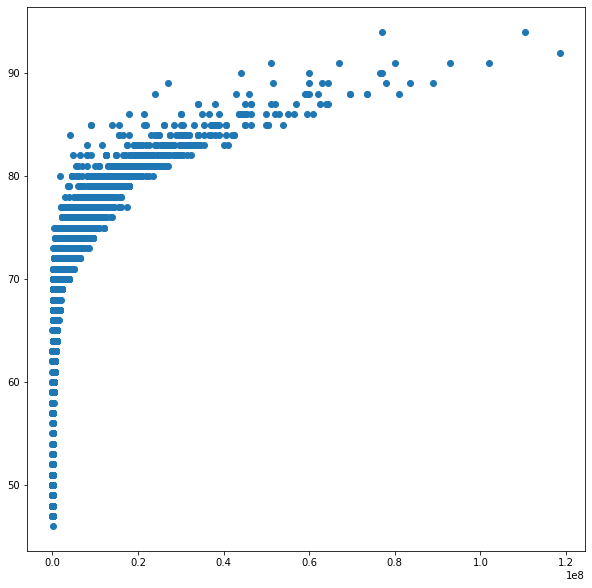

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(df['value'], df['overall'])

In [66]:
# Scale the data and select a subset for comparing algorithms

scaler = StandardScaler()
X = scaler.fit_transform(df.select_dtypes(include='number'))

indices = np.random.choice(14743,1000)

X = X[indices]

## K-means
Assumptions
- K clusters in the data
- clusters are isotropic
- similar variance

## Hierarchical
Assumptions and Considerations
- Linkage Method tuned to cluster shapes/composition


## DBSCAN
Assumptions and Considerations
- no need to supply a number of clusters
- one of the fastest methods
- true clusters must be linearly separable 

## GMM
- distributions must be gaussian
- soft clustering algorithm
- must supply K

## Dimensionality Reduction

In [15]:
import time

In [64]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=1,
                      metric='mahalanobis').fit_transform(X)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 12.91857385635376 seconds


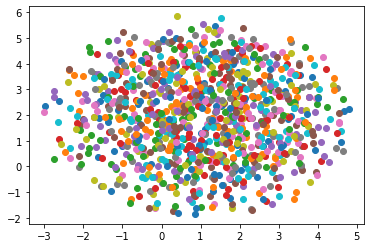

In [65]:
colors = ['red', 'black']
for i in range(umap_results.shape[0]):
    plt.scatter(umap_results[i, 0], umap_results[i, 1],
             #color=colors[int(y[i])],
             #fontdict={'weight': 'bold', 'size': 50}
        )

In [74]:
dist

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

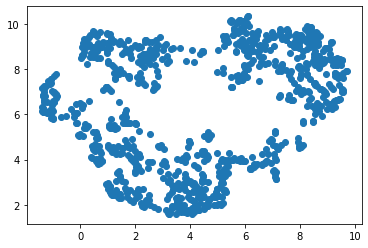

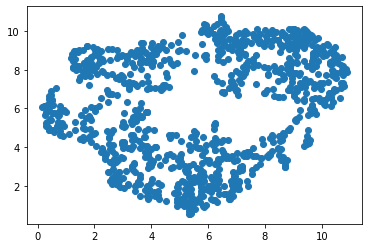

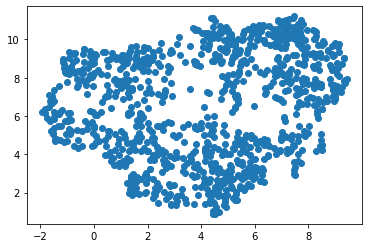

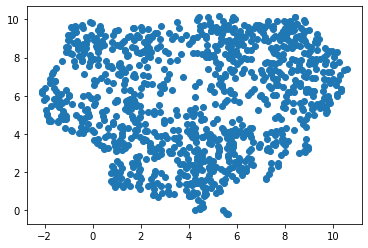

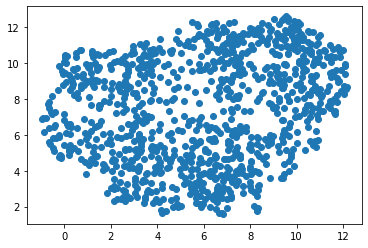

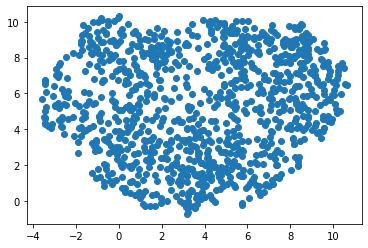

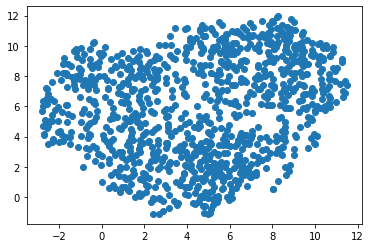

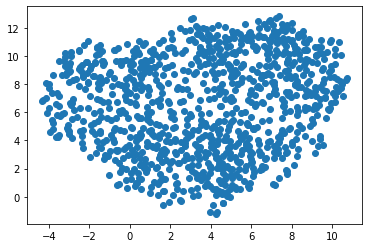

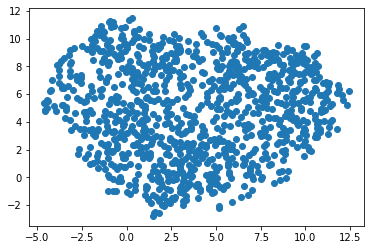

In [81]:
dists = np.arange(.1, 1, .1)

for dist in dists:
    umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=dist,
                      metric='cosine').fit_transform(X)
    plt.scatter(umap_results[:, 0], umap_results[:, 1])
    plt.show()
    

In [67]:
pca = PCA(n_components=2).fit_transform(X)

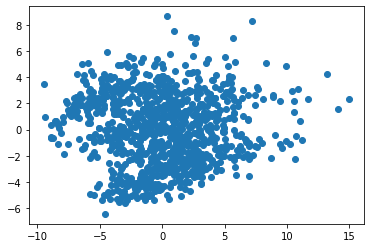

In [68]:
plt.scatter(pca[:, 0], pca[:, 1])